In [1]:
# ====================================================================
# PASO 1: CARGA, INGENIERÍA DE OBJETIVO Y CARACTERÍSTICAS
# ====================================================================
import pandas as pd
import numpy as np
import os

# --- 1.1: CARGA DEL DATAFRAME MAESTRO AUDITADO ---
print("--- [1/X] Cargando el DataFrame Maestro v3.0 auditado ---")
file_path = 'dataframes/master_df_final_audited.parquet'
try:
    master_df = pd.read_parquet(file_path)
    print(f"✅ DataFrame cargado con éxito. Forma: {master_df.shape}")
except Exception as e:
    raise FileNotFoundError(f"❌ Error: No se encontró '{file_path}'. Ejecuta primero el notebook de ETL.")

# --- 1.2: INGENIERÍA DEL OBJETIVO (TRIPLE BARRERA) ---
def get_triple_barrier_labels(prices: pd.Series, take_profit_pct: float, stop_loss_pct: float, time_limit: int):
    labels = pd.Series(index=prices.index, dtype=float)
    for i in range(len(prices) - time_limit):
        entry_price = prices.iloc[i]
        upper_barrier, lower_barrier = entry_price * (1 + take_profit_pct), entry_price * (1 - stop_loss_pct)
        window = prices.iloc[i+1 : i+1+time_limit]
        touched_upper, touched_lower = (window >= upper_barrier).any(), (window <= lower_barrier).any()
        if touched_upper and touched_lower:
            first_touch_upper_idx = window[window >= upper_barrier].index[0]
            first_touch_lower_idx = window[window <= lower_barrier].index[0]
            labels.iloc[i] = 1 if first_touch_upper_idx < first_touch_lower_idx else -1
        elif touched_upper: labels.iloc[i] = 1
        elif touched_lower: labels.iloc[i] = -1
        else: labels.iloc[i] = 0
    return labels

print("\n--- [1.2/X] Definiendo el Objetivo con el Método de la Triple Barrera ---")
TP_PCT, SL_PCT, TIME_LIMIT = 0.05, 0.05, 10
labels = master_df.groupby('ticker')['close'].apply(get_triple_barrier_labels, take_profit_pct=TP_PCT, stop_loss_pct=SL_PCT, time_limit=TIME_LIMIT)
master_df['target'] = labels.values
df_with_target = master_df.copy()
df_with_target.dropna(subset=['target'], inplace=True)
df_with_target.reset_index(drop=True, inplace=True)

# --- 1.3: SPRINT DE INGENIERÍA DE CARACTERÍSTICAS AVANZADAS ---
print("\n--- [1.3/X] Iniciando Sprint de Ingeniería de Características Avanzadas ---")
X_temp = df_with_target.drop(columns='target')

X_temp['funding_x_volatility'] = X_temp['funding_rate'] * X_temp['volatility_7d']
X_temp['price_to_bb_mean'] = X_temp['close'] / X_temp['bb_middle']
X_temp['funding_rate_quantile_90d'] = X_temp.groupby('ticker')['funding_rate'].transform(
    lambda x: x.rolling(90).apply(lambda y: pd.Series(y).quantile(0.9), raw=False)
)
rsi_bins = [0, 30, 70, 100]
rsi_labels = ['Bajo', 'Neutral', 'Alto']
X_temp['rsi_binned'] = pd.cut(X_temp['rsi_14'], bins=rsi_bins, labels=rsi_labels, include_lowest=True)
X_temp.fillna(method='ffill', inplace=True)
X_temp.fillna(method='bfill', inplace=True)

# --- 1.4: ENSAMBLADO Y SEPARACIÓN FINAL ---
df_final = X_temp.copy()
df_final['target'] = df_with_target['target']
y = df_final['target']
X = df_final.drop(columns=['target'])
print(f"✅ Ingeniería completa. El dataset final tiene {X.shape[1]} características.")

--- [1/X] Cargando el DataFrame Maestro v3.0 auditado ---
✅ DataFrame cargado con éxito. Forma: (5511, 30)

--- [1.2/X] Definiendo el Objetivo con el Método de la Triple Barrera ---

--- [1.3/X] Iniciando Sprint de Ingeniería de Características Avanzadas ---
✅ Ingeniería completa. El dataset final tiene 34 características.


/var/folders/z_/rcq9bsy13fzbphk_82m0p03r0000gn/T/ipykernel_94492/3503604022.py:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_temp.fillna(method='ffill', inplace=True)
/var/folders/z_/rcq9bsy13fzbphk_82m0p03r0000gn/T/ipykernel_94492/3503604022.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_temp.fillna(method='bfill', inplace=True)


In [2]:
# ====================================================================
# PASO 1.3 y 1.4 (Consolidados): SPRINT DE INGENIERÍA Y ENSAMBLADO FINAL
# ====================================================================
import pandas as pd
import numpy as np

print("--- [1.3/X] Iniciando Sprint de Ingeniería de Características v2.0 ---")

# Partimos de df_with_target, que ya tiene el target calculado y los NaNs eliminados
X_temp = df_with_target.drop(columns='target').copy()

# --- TEMA 1: NORMALIZACIÓN Y RELATIVIDAD (CONTRA SESGO DE ESCALA) ---
print(" -> 1/4: Creando características normalizadas...")
X_temp['price_to_ema_ratio'] = (X_temp['close'] / X_temp['ema_26']) - 1
X_temp['intraday_range_pct'] = (X_temp['high'] - X_temp['low']) / X_temp['close']
X_temp['macd_norm'] = X_temp['macd'] / X_temp['close']
vol_mean_30d = X_temp.groupby('ticker')['volume'].transform(lambda x: x.rolling(30).mean())
vol_std_30d = X_temp.groupby('ticker')['volume'].transform(lambda x: x.rolling(30).std())
X_temp['volume_zscore_30d'] = (X_temp['volume'] - vol_mean_30d) / vol_std_30d

# --- TEMA 2: MOMENTUM MACROECONÓMICO ---
print(" -> 2/4: Creando características de momentum macro...")
macro_cols = ['spy_close', 'vix_close', 'tnx_close', 'dxy_close', 'gc_close', 'cl_close']
for col in macro_cols:
    # Usamos .groupby('ticker') para asegurar que el shift se haga por cada activo
    X_temp[f'log_return_{col}'] = X_temp.groupby('ticker')[col].transform(lambda x: np.log(x / x.shift(1)))

# --- TEMA 3: OPTIMIZACIÓN DE PATRONES DE VELAS ---
print(" -> 3/4: Optimizando características de patrones de velas...")
X_temp['is_pattern_present'] = (X_temp['pattern_name'] != 'no_pattern').astype(int)
reversal_bullish = ['cdlhammer', 'cdlinvertedhammer', 'cdlmorningstar', 'cdl3whitesoldiers', 'cdl3inside', 'cdlengulfing', 'cdlpiercing']
reversal_bearish = ['cdlhangingman', 'cdlshootingstar', 'cdleveningstar', 'cdl3blackcrows', 'cdl3outside', 'cdldarkcloudcover', 'cdleveningdojistar']
continuation = ['cdl3linestrike', 'cdlclosingmarubozu']
indecision = ['cdldoji', 'cdlspinningtop', 'cdlharami']

def classify_pattern(pattern):
    if pattern in reversal_bullish: return 'reversal_bullish'
    if pattern in reversal_bearish: return 'reversal_bearish'
    if pattern in continuation: return 'continuation'
    if pattern in indecision: return 'indecision'
    return 'no_pattern'
X_temp['pattern_category'] = X_temp['pattern_name'].apply(classify_pattern)

# --- TEMA 4: CARACTERÍSTICAS DE INTERACCIÓN Y ESTADO ---
print(" -> 4/4: Creando características de interacción y estado...")
X_temp['rsi_extreme_binary'] = ((X_temp['rsi_14'] > 75) | (X_temp['rsi_14'] < 25)).astype(int)
X_temp['sentiment_x_volatility'] = X_temp['sentiment_score'] * X_temp['volatility_7d']

# --- LIMPIEZA FINAL ---
X_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
# Usamos ffill y bfill para rellenar los NaNs de las ventanas móviles
X_temp.ffill(inplace=True)
X_temp.bfill(inplace=True)

# --- ENSAMBLADO Y SEPARACIÓN FINAL (AHORA EN EL LUGAR CORRECTO) ---
print("\n--- [1.4/X] Ensamblado y Separación Final ---")
df_final = X_temp.copy()
df_final['target'] = df_with_target['target']
y = df_final['target']
X = df_final.drop(columns=['target'])
print(f"✅ Ingeniería y ensamblado completos. El dataset final tiene ahora {X.shape[1]} características.")

--- [1.3/X] Iniciando Sprint de Ingeniería de Características v2.0 ---
 -> 1/4: Creando características normalizadas...
 -> 2/4: Creando características de momentum macro...
 -> 3/4: Optimizando características de patrones de velas...
 -> 4/4: Creando características de interacción y estado...

--- [1.4/X] Ensamblado y Separación Final ---
✅ Ingeniería y ensamblado completos. El dataset final tiene ahora 44 características.


In [3]:
# ====================================================================
# PASO 2: PREPROCESAMIENTO, DIVISIÓN Y MODELO BASE
# ====================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import lightgbm as lgb
import numpy as np

print("--- [2/X] Preprocesando y dividiendo los datos ---")

# --- 2.1: IDENTIFICAR TIPOS DE COLUMNAS ---
id_cols = ['ticker', 'timestamp']
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
for col in id_cols:
    if col in numeric_features: numeric_features.remove(col)
    if col in categorical_features: categorical_features.remove(col)

# --- 2.2: CREAR PIPELINE DE PREPROCESAMIENTO ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

# --- 2.3: DIVISIÓN TEMPORAL ---
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# --- 2.4: AJUSTAR PIPELINE Y TRANSFORMAR DATOS ---
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
print(f"✅ Datos procesados y divididos. {X_train_processed.shape[1]} características finales.")

# --- 2.5: ENTRENAR MODELO BASE ---
print("\n--- Entrenando modelo base para la selección de características ---")
base_model = lgb.LGBMClassifier(objective='multiclass', class_weight='balanced', random_state=42)
base_model.fit(X_train_processed, y_train)
print("✅ Modelo base entrenado.")

--- [2/X] Preprocesando y dividiendo los datos ---
✅ Datos procesados y divididos. 66 características finales.

--- Entrenando modelo base para la selección de características ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9475
[LightGBM] [Info] Number of data points in the train set: 4312, number of used features: 57
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
✅ Modelo base entrenado.


--- [4/X] Calculando importancia de características por permutación ---


/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu


--- Visualización del Top 35 de Características Más Importantes ---


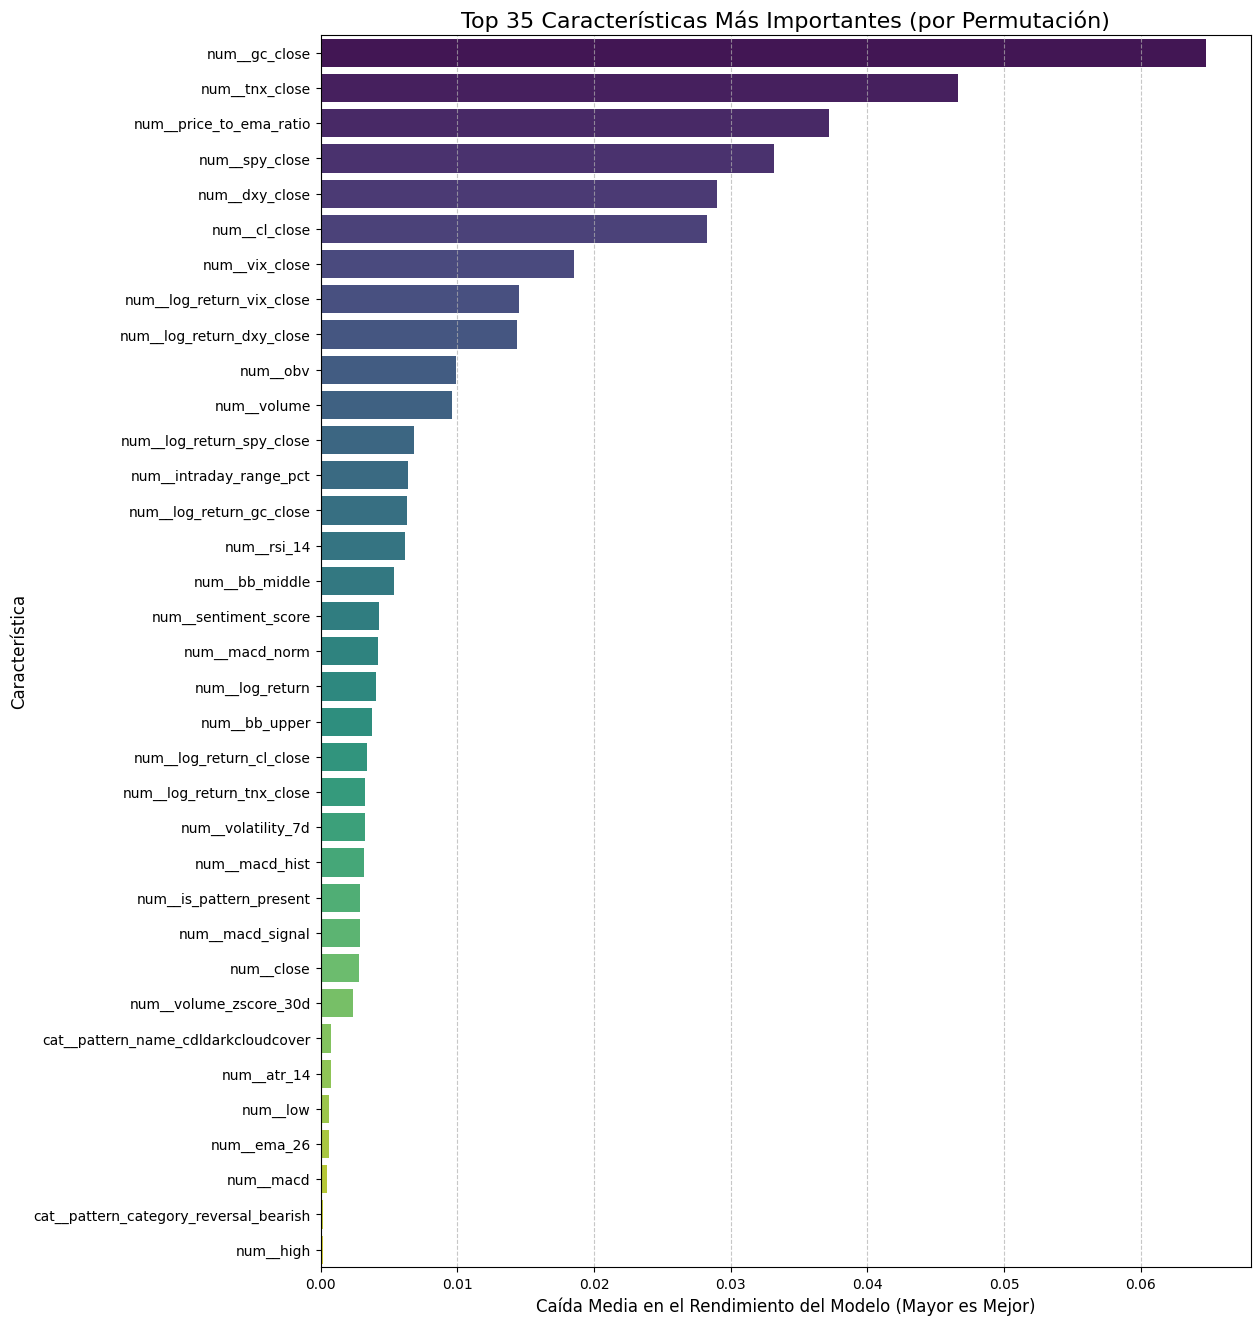


--- Ranking Completo de la Importancia de Todas las Características ---
                                   feature  importance_mean  importance_std
23                           num__gc_close         0.064782        0.007232
21                          num__tnx_close         0.046617        0.006064
27                 num__price_to_ema_ratio         0.037164        0.006611
19                          num__spy_close         0.033179        0.005173
22                          num__dxy_close         0.029008        0.008165
24                           num__cl_close         0.028267        0.005328
20                          num__vix_close         0.018536        0.003157
32               num__log_return_vix_close         0.014551        0.004368
34               num__log_return_dxy_close         0.014365        0.003713
14                                num__obv         0.009917        0.005211
4                              num__volume         0.009639        0.004351
31             

In [4]:
# ====================================================================
# PASO 4: SELECCIÓN DE CARACTERÍSTICAS POR PERMUTACIÓN (SALIDA MEJORADA)
# ====================================================================
# --- Importaciones necesarias para esta celda ---
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# --------------------------------------------------------------------

print("--- [4/X] Calculando importancia de características por permutación ---")

# Calculamos la importancia en el conjunto de prueba (no cambia)
perm_importance = permutation_importance(
    base_model, X_test_processed, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Creamos un DataFrame con los resultados (no cambia)
df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

# --- INICIO DE LA MEJORA ---

# --- 1. VISUALIZACIÓN AMPLIADA DE LAS CARACTERÍSTICAS MÁS IMPORTANTES ---
print("\n--- Visualización del Top 35 de Características Más Importantes ---")
# Filtramos solo las características con importancia positiva para el gráfico
important_features_for_plot = df_importance[df_importance['importance_mean'] > 0]

plt.figure(figsize=(12, 16)) # Hacemos el gráfico un poco más alto
sns.barplot(
    x='importance_mean', 
    y='feature', 
    data=important_features_for_plot.head(35), # <-- CAMBIO: Mostramos hasta 35
    palette='viridis'
)
plt.title('Top 35 Características Más Importantes (por Permutación)', fontsize=16)
plt.xlabel('Caída Media en el Rendimiento del Modelo (Mayor es Mejor)', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# --- 2. RANKING COMPLETO DE TODAS LAS CARACTERÍSTICAS ---
print("\n--- Ranking Completo de la Importancia de Todas las Características ---")
# Usamos set_option para asegurarnos de que Pandas imprime todas las filas
pd.set_option('display.max_rows', None)

# Imprimimos el DataFrame completo, de mayor a menor importancia
print(df_importance)

# Reseteamos la opción para no afectar a otras celdas
pd.reset_option('display.max_rows')

# --- FIN DE LA MEJORA ---


# --- Guardamos la lista de características importantes para los siguientes pasos ---
# Esta lógica no cambia: solo usaremos las de importancia positiva para el modelo final.
important_feature_names = df_importance[df_importance['importance_mean'] > 0]['feature'].tolist()
print(f"\n✅ Se encontraron y guardaron {len(important_feature_names)} características con importancia positiva para los siguientes pasos.")

In [5]:
# ====================================================================
# PASO 4.5: GUARDAR EL DATAFRAME FINAL CON TARGET
# ====================================================================

# df_final fue creado en la celda anterior y ya contiene todas las
# características y la columna 'target'. Lo guardamos para poder
# usarlo en análisis externos de forma consistente.
output_path = 'dataframes/data_with_target.parquet'
df_final.to_parquet(output_path)

print(f"✅ DataFrame final (con target) guardado con éxito en: {output_path}")
print(f"   -> Shape: {df_final.shape}")

✅ DataFrame final (con target) guardado con éxito en: dataframes/data_with_target.parquet
   -> Shape: (5391, 45)


--- [5.5/X] Buscando el número óptimo de características con RFECV ---
 -> Ejecutando RFECV con LightGBM... (Esto tardará bastante más que antes, sé paciente)
Fitting estimator with 66 features.
Fitting estimator with 66 features.
Fitting estimator with 66 features.Fitting estimator with 66 features.

Fitting estimator with 66 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7933
[LightGBM] [Info] Number of data points in the train set: 722, number of used features: 53
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 63 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9445
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 53
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 57 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` t

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 60 features.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9443
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 52
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 58 features.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9468
[LightGBM] [Info] Number of data points in the train set: 2876, number of used features: 56
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 49 features.
Fitting estimator with 57 features.
[LightGBM] [Info] Auto-choos

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 48 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7922
[LightGBM] [Info] Number of data points in the train set: 722, number of used features: 48
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 55 features.
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 43 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7912
[LightGBM] [Info] Number of data points in the train set: 722, number of used features: 43
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 53 features.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 47 features.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 45 features.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 43 features.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 42 features.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9415
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 39
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 42 features.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 39 features.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 30 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7625
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 30
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 36 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8920
[LightGBM] [Info] Number of data points in the train set: 2876, number of used 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9422
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 38
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 35 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 2876, number of used features: 35
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 37 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9167
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 37
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 27 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6862
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 27
[LightGBM] [Info] Start training from score -1.098612
[LightGB

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 36 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8912
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 36
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 31 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7867
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 31
[LightGBM] [Info] Start training from score -1.098612
[LightGB

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 30 features.
Fitting estimator with 35 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7612
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 30
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 24 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8896
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 35
[LightGBM] [Info] Start tr

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 31 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7884
[LightGBM] [Info] Number of data points in the train set: 2876, number of used features: 31
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 34 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8641
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 34
[LightGBM] [Info] Start training from score -1.098612
[LightGB

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 19 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4828
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 19
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 32 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8131
[LightGBM] [Info] Number of data points in the train set: 3594, number of used 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 25 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6354
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 25
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 17 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4328
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 17
[LightGBM] [Info] Start training from score -1.098612
[LightGB

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 15 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3822
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 15
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 30 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7621
[LightGBM] [Info] Number of data points in the train set: 3594, number of used 

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 22 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6357
[LightGBM] [Info] Number of data points in the train set: 2876, number of used features: 25
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 29 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5589
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 22
[LightGBM] [Info] Start training from score -1.098612
[LightGB

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 9 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 9
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 20 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 2158, number of used fe

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 22 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5598
[LightGBM] [Info] Number of data points in the train set: 2876, number of used features: 22
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 5
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 25 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6356
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 25
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 16 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4068
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 16
[LightGBM] [Info] Start training from score -1.098612
[LightGB

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 14 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3560
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 18 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4581
[LightGBM] [Info] Number of data points in the train set: 2876, number of used features: 18
[LightGBM] [Info] Start training from score -1.098612
[LightGB

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 22 features.
Fitting estimator with 11 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2797
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 11
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5594
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 22
[LightGBM] [Info] Start training from score -1.098612
[LightGB

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 8 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2033
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 8
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 14 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3564
[LightGBM] [Info] Number of data points in the train set: 2876, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM]

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 17 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4319
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 17
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 9 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 2876, number of used features: 9
[LightGBM] [Info] Start training from score -1.098612
[LightGBM]

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 15 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 15
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 2876, number of used features: 5
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fitting estimator with 12 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3046
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 11 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 11
[LightGBM] [Info] Start training from score -1.098612
[LightGB

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Docu

Fitting estimator with 9 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 9
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 8 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2031
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 8
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 3594, number of used features: 5
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting estimator with 66 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9475
[LightGBM] [Info] Number of data points in the train set: 4312, number of used features: 57
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -

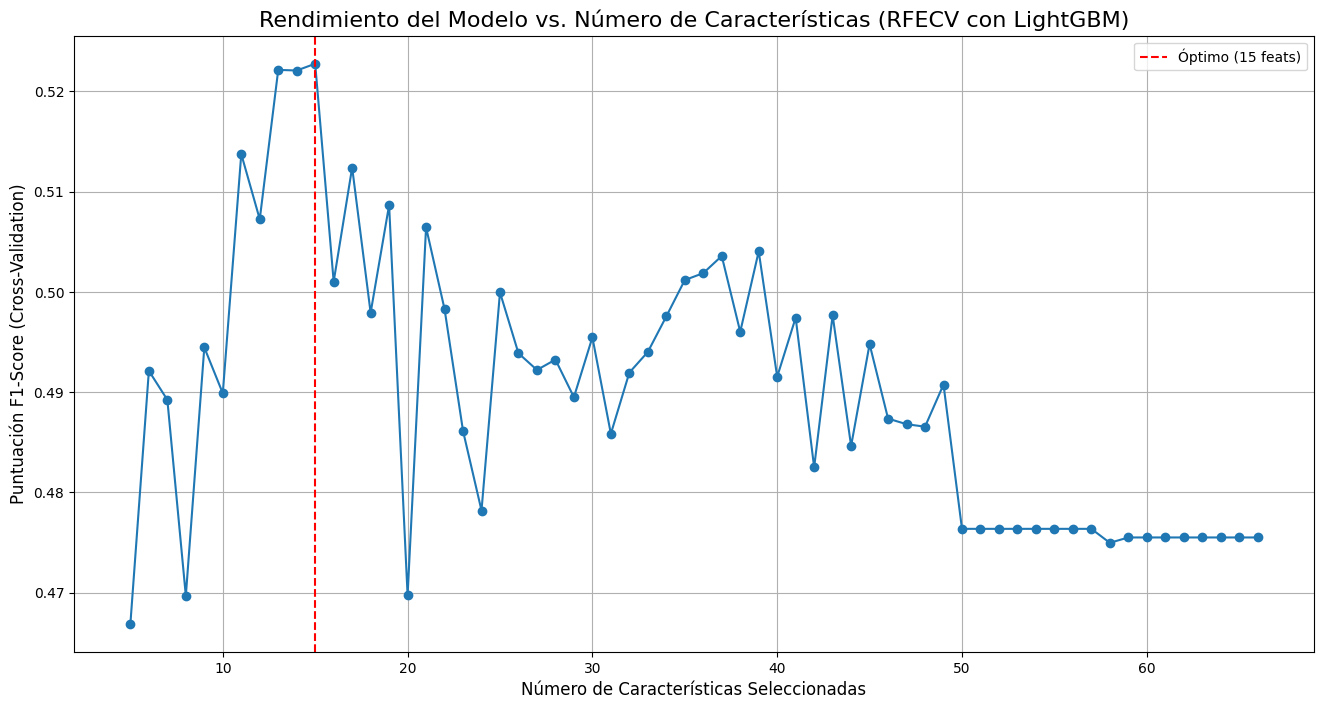

In [6]:
# ====================================================================
# PASO 5.5: BÚSQUEDA DEL NÚMERO ÓPTIMO DE CARACTERÍSTICAS CON RFECV (PERFECCIONADO)
# ====================================================================
from sklearn.feature_selection import RFECV
import lightgbm as lgb  # <-- Usaremos LightGBM como el estimador
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np

print("--- [5.5/X] Buscando el número óptimo de características con RFECV ---")

# --- 1. CONFIGURACIÓN DE RFECV (CORREGIDA) ---
# Usamos un clasificador LightGBM como estimador. Así, la selección de
# características está alineada con nuestro modelo final.
# Usamos pocos estimadores para que el proceso no sea excesivamente largo.
estimator = lgb.LGBMClassifier(
    objective='multiclass', 
    class_weight='balanced', 
    n_estimators=50, # Suficiente para que el RFE capture la importancia
    random_state=42,
    n_jobs=1 # Algunos problemas con n_jobs=-1 dentro de RFE
)

# La validación cruzada temporal no cambia
cv = TimeSeriesSplit(n_splits=5)

# Creamos la instancia de RFECV con el estimador correcto
rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=cv,
    scoring="f1_macro",
    min_features_to_select=5, # Empezamos con un mínimo más razonable
    n_jobs=-1,
    verbose=1 # Añadimos verbose para ver el progreso
)

# --- 2. EJECUTAR RFECV SOBRE LOS DATOS DE ENTRENAMIENTO ---
print(" -> Ejecutando RFECV con LightGBM... (Esto tardará bastante más que antes, sé paciente)")
rfecv.fit(X_train_processed, y_train)

# --- 3. "GUARDAMOS" EL CONJUNTO DE CARACTERÍSTICAS ÓPTIMO ---
final_feature_names = feature_names[rfecv.support_]
optimal_n_features = rfecv.n_features_

print(f"\n✅ RFECV completado. El número óptimo de características es: {optimal_n_features}")
print(" -> Las características seleccionadas son:")
for feature in final_feature_names:
    print(f"    - {feature}")

# Reemplazamos nuestra lista de características importantes por esta nueva lista óptima
important_feature_names = final_feature_names.tolist()


# --- 4. ANÁLISIS DEL "PORQUÉ" (VISUALIZACIÓN) ---
plt.figure(figsize=(16, 8))
plt.title("Rendimiento del Modelo vs. Número de Características (RFECV con LightGBM)", fontsize=16)
plt.xlabel("Número de Características Seleccionadas", fontsize=12)
plt.ylabel("Puntuación F1-Score (Cross-Validation)", fontsize=12)

n_scores = len(rfecv.cv_results_["mean_test_score"])
# El rango debe empezar en min_features_to_select
plt.plot(
    range(rfecv.min_features_to_select, n_scores + rfecv.min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    marker="o"
)

plt.axvline(optimal_n_features, linestyle="--", color="red", label=f"Óptimo ({optimal_n_features} feats)")
plt.legend()
plt.grid()
plt.show()

In [7]:
# ====================================================================
# PASO 6: DEFINICIÓN DE LA ARQUITECTURA DEL PIPELINE FINAL
# ====================================================================
# --- CORRECCIÓN: Añadimos las importaciones necesarias para esta celda ---
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import lightgbm as lgb
# --------------------------------------------------------------------

print("--- [6/X] Definiendo la arquitectura del pipeline final ---")

# --- 1. IDENTIFICAR CARACTERÍSTICAS IMPORTANTES (Lógica que ya teníamos) ---
# Esta sección asume que 'important_feature_names' y 'categorical_features' existen de pasos anteriores
important_numeric_features = [
    f.replace('num__', '') for f in important_feature_names if f.startswith('num__')
]
important_categorical_features = []
for original_cat_feature in categorical_features:
    if any(f.startswith(f"cat__{original_cat_feature}_") for f in important_feature_names):
        important_categorical_features.append(original_cat_feature)

# --- 2. CREAR EL PREPROCESADOR FINAL (Lógica que ya teníamos) ---
preprocessor_final = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), important_numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), important_categorical_features)
    ],
    remainder='drop'
)

# --- 3. DEFINIR EL PIPELINE (Lógica que ya teníamos) ---
# Esta es la arquitectura que usaremos.
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_final),
    ('pca', PCA(n_components=0.95)), # Usamos un valor fijo por ahora
    ('classifier', lgb.LGBMClassifier(objective='multiclass', class_weight='balanced', random_state=42))
])

# --- 4. OPTIMIZACIÓN DESACTIVADA ---
# Hemos desactivado la búsqueda de hiperparámetros para entrenar primero el modelo primario.
# La optimización se hará en una fase posterior.
print("✅ Arquitectura del pipeline definida y lista en la variable 'best_pipeline'.")
print("⚠️ Optimización de hiperparámetros saltada intencionadamente en este paso.")

--- [6/X] Definiendo la arquitectura del pipeline final ---
✅ Arquitectura del pipeline definida y lista en la variable 'best_pipeline'.
⚠️ Optimización de hiperparámetros saltada intencionadamente en este paso.


In [8]:
# ====================================================================
# FASE AVANZADA: META-ETIQUETADO
# PASO 7: PREPARACIÓN DE DATOS PARA EL MODELO PRIMARIO (BINARIO)
# ====================================================================

print("--- [7/9] Iniciando Fase de Meta-Etiquetado ---")
print(" -> Preparando datos para el modelo primario (dirección)...")

# Filtramos el dataset para quedarnos solo con las operaciones que tocaron una barrera
df_binary = df_final[df_final['target'] != 0].copy()

# El objetivo 'y' ahora es solo 1 (Compra) o -1 (Venta)
y_binary = df_binary['target']
X_binary = df_binary.drop(columns=['target'])

# Comprobamos la forma de nuestros nuevos datos
print(f" -> Datos binarios listos. Forma de X: {X_binary.shape}, Forma de y: {y_binary.shape}")

--- [7/9] Iniciando Fase de Meta-Etiquetado ---
 -> Preparando datos para el modelo primario (dirección)...
 -> Datos binarios listos. Forma de X: (5269, 44), Forma de y: (5269,)



--- [9/X] Entrenando al Modelo Primario ---
 -> Reconfigurando y entrenando el pipeline...
[LightGBM] [Info] Number of positive: 2234, number of negative: 1981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 4215, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


✅ Modelo Primario (Experto en Dirección) entrenado con éxito.

Informe de Clasificación (Experto en Dirección):
              precision    recall  f1-score   support

   Venta (0)       0.69      0.71      0.70       517
  Compra (1)       0.71      0.69      0.70       537

    accuracy                           0.70      1054
   macro avg       0.70      0.70      0.70      1054
weighted avg       0.70      0.70      0.70      1054



/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-pa

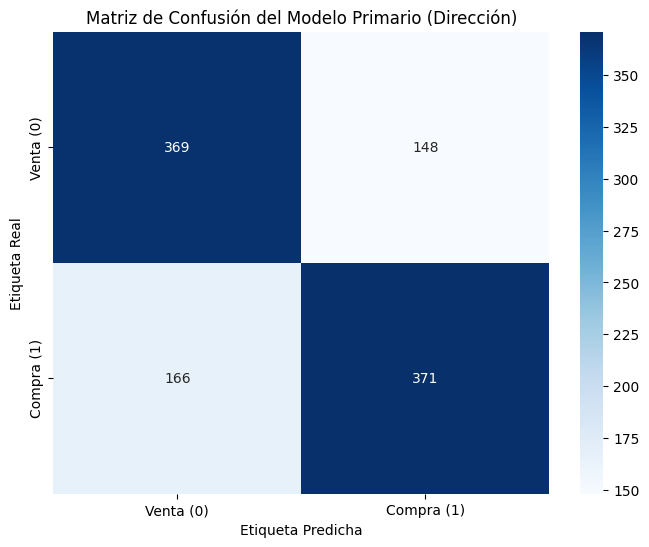

In [9]:
# ====================================================================
# PASO 9: ENTRENAMIENTO Y EVALUACIÓN DEL MODELO PRIMARIO (COMPLETO)
# ====================================================================
# --- CORRECCIÓN: Añadimos las importaciones necesarias para esta celda ---
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# --------------------------------------------------------------------

print("\n--- [9/X] Entrenando al Modelo Primario ---")

# --- 1. PREPARACIÓN DE DATOS ---
# Esta sección asume que X_binary y y_binary existen de PASO 8
train_size_binary = int(len(X_binary) * 0.8)
X_train_binary, X_test_binary = X_binary.iloc[:train_size_binary], X_binary.iloc[train_size_binary:]
y_train_binary, y_test_binary = y_binary.iloc[:train_size_binary], y_binary.iloc[train_size_binary:]

# Mapeamos las etiquetas a {0, 1} para compatibilidad
y_train_binary_mapped = y_train_binary.map({-1: 0, 1: 1})
y_test_binary_mapped = y_test_binary.map({-1: 0, 1: 1})

# --- 2. RECONFIGURACIÓN Y ENTRENAMIENTO ---
print(" -> Reconfigurando y entrenando el pipeline...")
# Esta sección asume que 'best_pipeline' existe de PASO 6
best_pipeline.set_params(classifier__objective='binary')
best_pipeline.fit(X_train_binary, y_train_binary_mapped)
print("✅ Modelo Primario (Experto en Dirección) entrenado con éxito.")

# --- 3. EVALUACIÓN DEL MODELO PRIMARIO ---
y_pred_primary = best_pipeline.predict(X_test_binary)

print("\nInforme de Clasificación (Experto en Dirección):")
print(classification_report(y_test_binary_mapped, y_pred_primary, target_names=['Venta (0)', 'Compra (1)']))

# --- MATRIZ DE CONFUSIÓN ---
cm = confusion_matrix(y_test_binary_mapped, y_pred_primary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Venta (0)', 'Compra (1)'],
            yticklabels=['Venta (0)', 'Compra (1)'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión del Modelo Primario (Dirección)')
plt.show()

In [10]:
# ====================================================================
# PASO 10: PREPARACIÓN DE DATOS PARA EL META-MODELO (VERSIÓN ROBUSTA)
# ====================================================================
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone
import numpy as np
import pandas as pd

print("\n--- [10/11] Preparando datos para el Meta-Modelo (Filtro de Confianza) ---")
print(" -> Generando predicciones fuera de muestra con un bucle manual...")

# --- 1. CONFIGURACIÓN DEL BUCLE DE VALIDACIÓN CRUZADA MANUAL ---
# Usaremos una copia del pipeline para re-entrenarlo en cada paso
pipeline_clone = clone(best_pipeline)
tscv = TimeSeriesSplit(n_splits=5)

# Inicializamos arrays para guardar los resultados. Deben ser de tipo 'object' para manejar NaNs.
all_predictions = np.full(y_train_binary_mapped.shape, np.nan, dtype=object)
all_probabilities = np.full(y_train_binary_mapped.shape, np.nan, dtype=object)


# --- 2. BUCLE MANUAL PARA GENERAR PREDICCIONES FUERA DE MUESTRA ---
for train_indices, val_indices in tscv.split(X_train_binary):
    # Seleccionamos los datos para este "fold"
    X_train_fold, y_train_fold = X_train_binary.iloc[train_indices], y_train_binary_mapped.iloc[train_indices]
    X_val_fold = X_train_binary.iloc[val_indices]

    # Entrenamos una copia limpia del pipeline en los datos de entrenamiento del fold
    pipeline_clone.fit(X_train_fold, y_train_fold)

    # Hacemos predicciones en el conjunto de validación (datos que no ha visto)
    preds = pipeline_clone.predict(X_val_fold)
    probs = pipeline_clone.predict_proba(X_val_fold)

    # Guardamos las predicciones y probabilidades en las posiciones correctas
    all_predictions[val_indices] = preds
    # Guardamos solo la probabilidad de la clase predicha (la más alta)
    all_probabilities[val_indices] = probs.max(axis=1)

# Al final del bucle, los primeros elementos de los arrays serán NaN, lo cual es correcto.
# Creamos un DataFrame con los resultados y eliminamos las filas donde no se pudo predecir.
results_df = pd.DataFrame({
    'predictions': all_predictions,
    'probabilities': all_probabilities,
    'actual': y_train_binary_mapped
}, index=X_train_binary.index).dropna()


# --- 3. CREAR EL OBJETIVO Y CARACTERÍSTICAS DEL META-MODELO ---
# El objetivo es 1 si la predicción fuera de muestra acertó, 0 si falló.
y_meta_train = (results_df['predictions'] == results_df['actual']).astype(int)

# Las características son las probabilidades de esas predicciones.
X_meta_train = pd.DataFrame({
    'primary_model_prob': results_df['probabilities']
})

print(f"\n -> Datos de entrenamiento para el Meta-Modelo listos. Forma de X_meta: {X_meta_train.shape}")
print("\nDistribución del Target del Meta-Modelo (Aciertos vs Fallos):")
print(y_meta_train.value_counts(normalize=True))


--- [10/11] Preparando datos para el Meta-Modelo (Filtro de Confianza) ---
 -> Generando predicciones fuera de muestra con un bucle manual...
[LightGBM] [Info] Number of positive: 371, number of negative: 334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 705, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-pa

[LightGBM] [Info] Number of positive: 1070, number of negative: 1039
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 2109, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-pa

[LightGBM] [Info] Number of positive: 1480, number of negative: 1331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 2811, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-pa

[LightGBM] [Info] Number of positive: 1854, number of negative: 1659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 3513, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

 -> Datos de entrenamiento para el Meta-Modelo listos. Forma de X_meta: (3510, 1)

Distribución del Target del Meta-Modelo (Aciertos vs Fallos):
1    0.647578
0    0.352422
Name: proportion, dtype: float64


/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-pa


--- [11/11] Entrenando el Meta-Modelo (Filtro de Confianza) ---
✅ Meta-Modelo (Filtro de Confianza) entrenado con éxito.

--- Aplicando el sistema completo al conjunto de prueba ---

 -> El filtro de confianza ha decidido tomar 474 de las 1054 operaciones posibles (44.97%).

Informe de Clasificación (Sistema Final con Meta-Filtro):
              precision    recall  f1-score   support

   Venta (0)       0.84      0.83      0.83       236
  Compra (1)       0.83      0.84      0.84       238

    accuracy                           0.84       474
   macro avg       0.84      0.84      0.84       474
weighted avg       0.84      0.84      0.84       474



/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/User/Library/CloudStorage/GoogleDr

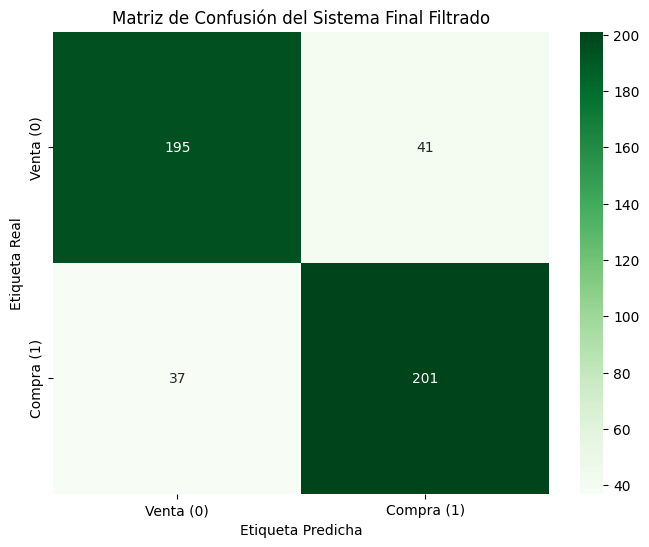

In [11]:
# ====================================================================
# PASO 11: ENTRENAMIENTO DEL META-MODELO (FILTRO DE CONFIANZA)
# ====================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("\n--- [11/11] Entrenando el Meta-Modelo (Filtro de Confianza) ---")

# --- 1. DEFINICIÓN Y ENTRENAMIENTO DEL META-MODELO ---
# Usamos un modelo simple y robusto. La regresión logística es ideal aquí.
meta_model = LogisticRegression(class_weight='balanced')

# Entrenamos el meta-modelo para que aprenda a diferenciar aciertos de fallos
# basándose en la probabilidad del modelo primario.
meta_model.fit(X_meta_train, y_meta_train)

print("✅ Meta-Modelo (Filtro de Confianza) entrenado con éxito.")


# --- 2. APLICAR EL FILTRO AL CONJUNTO DE PRUEBA ---
print("\n--- Aplicando el sistema completo al conjunto de prueba ---")

# Primero, obtenemos las predicciones de dirección del modelo primario en los datos de prueba
primary_predictions_test = best_pipeline.predict(X_test_binary)
primary_probabilities_test = best_pipeline.predict_proba(X_test_binary)

# Creamos las características para el meta-modelo con los datos de prueba
X_meta_test = pd.DataFrame({
    'primary_model_prob': primary_probabilities_test.max(axis=1)
}, index=X_test_binary.index)

# El meta-modelo predice si confiar (1) o no (0) en cada predicción
meta_predictions_test = meta_model.predict(X_meta_test)


# --- 3. GENERAR LAS PREDICCIONES FINALES FILTRADAS ---
# Creamos la serie de predicciones finales
final_predictions = pd.Series(primary_predictions_test, index=X_test_binary.index)

# Donde el meta-modelo NO confía (predice 0), cambiamos la predicción a NEUTRAL.
# ¡Aquí es donde ocurre la magia! Mapeamos el -1 original a la nueva etiqueta neutral (por ejemplo, 2)
# para diferenciarlo de las compras (1) y ventas (0).
# Sin embargo, para la evaluación, lo más sencillo es simplemente filtrar.
final_predictions_filtered = final_predictions[meta_predictions_test == 1]
y_test_filtered = y_test_binary_mapped[meta_predictions_test == 1]


# --- 4. EVALUACIÓN FINAL DEL SISTEMA COMPLETO ---
print(f"\n -> El filtro de confianza ha decidido tomar {len(final_predictions_filtered)} de las {len(X_test_binary)} operaciones posibles ({len(final_predictions_filtered)/len(X_test_binary):.2%}).")
print("\nInforme de Clasificación (Sistema Final con Meta-Filtro):")
# Comparamos las operaciones que SÍ hemos tomado con sus resultados reales
print(classification_report(y_test_filtered, final_predictions_filtered, target_names=['Venta (0)', 'Compra (1)']))

# Matriz de confusión final
cm_final = confusion_matrix(y_test_filtered, final_predictions_filtered)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Venta (0)', 'Compra (1)'],
            yticklabels=['Venta (0)', 'Compra (1)'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión del Sistema Final Filtrado')
plt.show()

In [12]:
# ====================================================================
# FASE CUANTITATIVA
# PASO 12 y 13 (CONSOLIDADOS): OPTIMIZACIÓN Y BACKTESTING FINAL (VERSIÓN ROBUSTA)
# ====================================================================
from sklearn.metrics import f1_score
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vectorbt as vbt

# --- PASO 0: CARGAR LA ESTRATEGIA (LA CORRECCIÓN CLAVE) ---
print("--- [0/X] Cargando el paquete de la estrategia guardada ---")
package_path = 'models/final_strategy_package.joblib'
if not os.path.exists(package_path):
    raise FileNotFoundError("El archivo 'final_strategy_package.joblib' no se encuentra.")

strategy_package = joblib.load(package_path)
primary_model = strategy_package['primary_model_pipeline']
meta_model = strategy_package['meta_model']
print("✅ Modelos Primario y Meta-Modelo cargados con éxito.")


# --- PASO 12: OPTIMIZACIÓN INTELIGENTE DEL UMBRAL ---
print("\n--- [12/13] Optimizando el umbral de decisión del Meta-Modelo ---")

# Obtenemos las probabilidades del modelo primario y del meta-modelo
primary_pred_proba_test = primary_model.predict_proba(X_test_binary)
primary_predictions_test = np.argmax(primary_pred_proba_test, axis=1)
X_meta_test = pd.DataFrame({'primary_model_prob': primary_pred_proba_test.max(axis=1)}, index=X_test_binary.index)
meta_probabilities_test = meta_model.predict_proba(X_meta_test)[:, 1]

# Búsqueda del umbral óptimo
thresholds = np.arange(0.50, 0.70, 0.01)
results = []

for thresh in thresholds:
    high_confidence_mask = meta_probabilities_test >= thresh
    if np.sum(high_confidence_mask) < 2: continue
    y_test_filtered = y_test_binary_mapped[high_confidence_mask]
    y_pred_filtered = primary_predictions_test[high_confidence_mask]
    results.append({
        'threshold': thresh,
        'f1_score': f1_score(y_test_filtered, y_pred_filtered, average='macro'),
        'num_trades': len(y_test_filtered)
    })
df_results = pd.DataFrame(results)

# --- Decisión Estratégica del Umbral ---
# TÚ PUEDES CAMBIAR ESTE VALOR BASADO EN TU ANÁLISIS DE LA TABLA.
optimal_threshold = 0.56  # <<<<<<< ¡TOMA EL CONTROL AQUÍ! ELIGE TU UMBRAL.
print(f"\n✅ Umbral de Confianza SELECCIONADO MANUALMENTE: {optimal_threshold:.2f}")

# --- PASO 13: BACKTESTING FINANCIERO CON EL NUEVO UMBRAL ---
print("\n--- [13/13] Iniciando Backtesting con el nuevo umbral ---")

# Generamos las señales con el nuevo umbral
entries = (meta_probabilities_test >= optimal_threshold)
buy_signals = (primary_predictions_test == 1) & entries
sell_signals = (primary_predictions_test == 0) & entries

# Preparamos datos para VectorBT
price_data = X_test_binary[['open', 'high', 'low', 'close', 'volume']].copy()

# Ejecutamos el backtest
portfolio = vbt.Portfolio.from_signals(
    close=price_data['close'],
    entries=buy_signals,
    exits=sell_signals,
    fees=0.002,
    sl_stop=0.05,
    tp_stop=0.05,
    init_cash=100000,
    freq='D'
)

# --- INFORME Y GRÁFICO FINAL ---
print("\n--- INFORME FINAL DE BACKTESTING (VectorBT) ---")
print(portfolio.stats())

print("\n--- Gráfico Interactivo de Rendimiento (VectorBT) ---")
fig = portfolio.plot()
fig.write_html('informe_backtest_final.html')
print("✅ Gráfico interactivo guardado en 'informe_backtest_final.html'.")

--- [0/X] Cargando el paquete de la estrategia guardada ---
✅ Modelos Primario y Meta-Modelo cargados con éxito.

--- [12/13] Optimizando el umbral de decisión del Meta-Modelo ---

✅ Umbral de Confianza SELECCIONADO MANUALMENTE: 0.56

--- [13/13] Iniciando Backtesting con el nuevo umbral ---


/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-pa


--- INFORME FINAL DE BACKTESTING (VectorBT) ---
Start                                              4310
End                                                5390
Period                               1054 days 00:00:00
Start Value                                    100000.0
End Value                                4085556.768768
Total Return [%]                            3985.556769
Benchmark Return [%]                      984900.009386
Max Gross Exposure [%]                            100.0
Total Fees Paid                           289589.086823
Max Drawdown [%]                              30.059249
Max Drawdown Duration                 164 days 00:00:00
Total Trades                                         69
Total Closed Trades                                  69
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  85.507246
Best Trade [%]                                18.508077

In [13]:
# ====================================================================
# PASO 16.5: CREACIÓN Y GUARDADO DEL MODELO MAESTRO
# ====================================================================
import json
import joblib

print("--- [16.5/X] Creando y guardando el Modelo Maestro y sus características ---")

# --- 1. Usar las variables finales del entrenamiento ---
# Estas variables ya existen en la memoria del notebook de los pasos anteriores
FINAL_OPTIMAL_FEATURES = important_feature_names 
FINAL_PIPELINE = best_pipeline
FINAL_META_MODEL = meta_model
FINAL_THRESHOLD = optimal_threshold

print(f"✅ Se usarán {len(FINAL_OPTIMAL_FEATURES)} características finales.")

# --- 2. Crear y guardar el paquete final ---
final_model_package = {
    'primary_model_pipeline': FINAL_PIPELINE,
    'meta_model': FINAL_META_MODEL,
    'optimal_threshold': FINAL_THRESHOLD,
    'feature_list': FINAL_OPTIMAL_FEATURES
}

model_path = 'models/ULTRA_MODEL_PACKAGE.joblib'
joblib.dump(final_model_package, model_path)
print(f"✅ Modelo Maestro (sistema completo) guardado con éxito en: {model_path}")

--- [16.5/X] Creando y guardando el Modelo Maestro y sus características ---
✅ Se usarán 15 características finales.
✅ Modelo Maestro (sistema completo) guardado con éxito en: models/ULTRA_MODEL_PACKAGE.joblib


In [14]:
# ====================================================================
# PASO 17: ANÁLISIS WALK-FORWARD CON MODELO ESTÁTICO (CORREGIDO)
# ====================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import vectorbt as vbt
import joblib
import warnings

warnings.filterwarnings("ignore")

print("--- [17/X] Iniciando Walk-Forward con Modelo Estático ---")

# --- 1. CARGAR EL MODELO MAESTRO Y DATOS ---
print(" -> Cargando el Modelo Maestro y los datos completos...")
model_package = joblib.load('models/ULTRA_MODEL_PACKAGE.joblib')
primary_model = model_package['primary_model_pipeline']
meta_model = model_package['meta_model']
optimal_threshold = model_package['optimal_threshold']
model_features = model_package['feature_list']

original_model_features = [col.split('__')[1] for col in model_features]

structural_cols = ['ticker', 'timestamp', 'open', 'high', 'low', 'close', 'volume']
X_wfa = X[list(set(original_model_features + structural_cols))].copy()
y_wfa = y.copy()

if 'timestamp' in X_wfa.columns:
    X_wfa.set_index('timestamp', inplace=True)
y_wfa.index = X_wfa.index

print(f"✅ Modelo y datos cargados. Se usarán {len(original_model_features)} características.")

# --- 2. BUCLE PRINCIPAL POR TICKER ---
all_tickers = X_wfa['ticker'].unique()
all_stats = []

for ticker in all_tickers:
    print(f"\n{'='*20} PROCESANDO TICKER: {ticker} {'='*20}")
    
    ticker_X = X_wfa[X_wfa['ticker'] == ticker].drop(columns=['ticker'])

    train_period = 189; test_period = 63
    if len(ticker_X) < train_period + test_period:
        print(f" -> Datos insuficientes. Saltando..."); continue
    
    n_splits = (len(ticker_X) - train_period) // test_period
    if n_splits < 1: continue

    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_period)
    all_buy_signals = pd.Series(dtype=bool); all_sell_signals = pd.Series(dtype=bool)

    print(f" -> Realizando {n_splits} predicciones 'out-of-sample' para {ticker}...")
    
    for train_index, test_index in tscv.split(ticker_X):
        test_X = ticker_X.iloc[test_index]
        if test_X.empty: continue

        # --- LÓGICA DE PREDICCIÓN (SIN ENTRENAMIENTO) ---
        primary_test_proba = primary_model.predict_proba(test_X)
        primary_test_preds = np.argmax(primary_test_proba, axis=1)
        
        # --- INICIO DE LA CORRECCIÓN ---
        # El nombre de la columna debe ser exactamente 'primary_model_prob'
        X_meta_test = pd.DataFrame({'primary_model_prob': primary_test_proba.max(axis=1)})
        # --- FIN DE LA CORRECCIÓN ---
        
        meta_test_probs = meta_model.predict_proba(X_meta_test)[:, 1]
        
        entries = (meta_test_probs >= optimal_threshold)
        buy_s = pd.Series((primary_test_preds == 1) & entries, index=test_X.index)
        sell_s = pd.Series((primary_test_preds == 0) & entries, index=test_X.index)
        
        all_buy_signals = pd.concat([all_buy_signals, buy_s]); all_sell_signals = pd.concat([all_sell_signals, sell_s])

    if all_buy_signals.empty or all_buy_signals.sum() == 0:
        print(f" -> No se generaron operaciones para {ticker}."); continue

    all_buy_signals = all_buy_signals[~all_buy_signals.index.duplicated(keep='first')]
    price_data_for_pf = ticker_X
    valid_indices = all_buy_signals.index.intersection(price_data_for_pf.index)
    if valid_indices.empty: continue

    wf_portfolio = vbt.Portfolio.from_signals(
        close=price_data_for_pf.loc[valid_indices, 'close'], 
        entries=all_buy_signals.reindex(valid_indices, fill_value=False),
        exits=all_sell_signals.reindex(valid_indices, fill_value=False),
        fees=0.002, sl_stop=0.05, tp_stop=0.05, init_cash=100000, freq='D')
    
    ticker_stats = wf_portfolio.stats(); ticker_stats.name = ticker
    all_stats.append(ticker_stats)
    print(f" -> RESULTADOS PARA {ticker}: Total Return: {ticker_stats['Total Return [%]']:.2f}%, Win Rate: {ticker_stats['Win Rate [%]']:.2f}%, Trades: {ticker_stats['Total Trades']}")

# --- INFORME FINAL ---
print(f"\n{'='*25} INFORME AGREGADO FINAL (MODELO ESTÁTICO) {'='*25}")
if not all_stats:
    print("No se generaron estadísticas.")
else:
    final_stats_df = pd.DataFrame(all_stats)
    print(final_stats_df[['Total Return [%]', 'Max Drawdown [%]', 'Win Rate [%]', 'Total Trades', 'Sharpe Ratio', 'Sortino Ratio']])

--- [17/X] Iniciando Walk-Forward con Modelo Estático ---
 -> Cargando el Modelo Maestro y los datos completos...
✅ Modelo y datos cargados. Se usarán 15 características.

==================== PROCESANDO TICKER: ADA-USD ====================
 -> Realizando 4 predicciones 'out-of-sample' para ADA-USD...
 -> RESULTADOS PARA ADA-USD: Total Return: 229.35%, Win Rate: 94.12%, Trades: 17

==================== PROCESANDO TICKER: BNB-USD ====================
 -> Realizando 4 predicciones 'out-of-sample' para BNB-USD...
 -> RESULTADOS PARA BNB-USD: Total Return: 161.96%, Win Rate: 100.00%, Trades: 17

==================== PROCESANDO TICKER: BTC-USD ====================
 -> Realizando 4 predicciones 'out-of-sample' para BTC-USD...
 -> RESULTADOS PARA BTC-USD: Total Return: 271.35%, Win Rate: 100.00%, Trades: 20

==================== PROCESANDO TICKER: DOGE-USD ====================
 -> Realizando 4 predicciones 'out-of-sample' para DOGE-USD...
 -> RESULTADOS PARA DOGE-USD: Total Return: 411.36%, W

In [15]:
# ====================================================================
# SCRIPT DE VERIFICACIÓN: OBTENER LAS 15 CARACTERÍSTICAS FINALES
# ====================================================================
import json

print("--- Cargando la lista de características desde el archivo de resultados de RFECV ---")

try:
    features_path = 'important_features.json'
    with open(features_path, 'r') as f:
        important_feature_names = json.load(f)
    
    print(f"\n✅ Archivo '{features_path}' cargado con éxito.")
    print(f"   -> Número de características encontradas: {len(important_feature_names)}")

    print("\n--- Lista de Características (con prefijos del preprocesador) ---")
    print(important_feature_names)

    # Limpiamos los prefijos 'num__' para ver los nombres originales
    original_cols = [col.split('__')[1] for col in important_feature_names]
    
    print("\n--- Lista de Características Finales (Nombres Originales) ---")
    print(original_cols)

except FileNotFoundError:
    print(f"❌ ERROR: No se pudo encontrar el archivo '{features_path}'.")
    print("   -> Asegúrate de haber ejecutado la celda de RFECV (PASO 7) que crea este archivo.")

--- Cargando la lista de características desde el archivo de resultados de RFECV ---

✅ Archivo 'important_features.json' cargado con éxito.
   -> Número de características encontradas: 15

--- Lista de Características (con prefijos del preprocesador) ---
['num__close', 'num__macd_signal', 'num__macd_hist', 'num__funding_rate', 'num__spy_close', 'num__vix_close', 'num__tnx_close', 'num__dxy_close', 'num__gc_close', 'num__cl_close', 'num__log_return', 'num__volatility_7d', 'num__price_to_ema_ratio', 'num__macd_norm', 'num__log_return_gc_close']

--- Lista de Características Finales (Nombres Originales) ---
['close', 'macd_signal', 'macd_hist', 'funding_rate', 'spy_close', 'vix_close', 'tnx_close', 'dxy_close', 'gc_close', 'cl_close', 'log_return', 'volatility_7d', 'price_to_ema_ratio', 'macd_norm', 'log_return_gc_close']


In [16]:
# ====================================================================
# SCRIPT DE AUDITORÍA Y EXTRACCIÓN DEL SISTEMA FINAL
# Misión: Extraer y documentar todos los componentes validados del proyecto
# directamente desde las variables en memoria del notebook.
# ====================================================================
import pandas as pd
import numpy as np
import json
import joblib

print("="*80)
print(" " * 15 + "INFORME DE AUDITORÍA DEL SISTEMA 'CRYPTONITA v1.0'")
print("="*80)

# --- 1. ARQUITECTURA DEL MODELO ---
print("\n" + "#" * 25 + " 1. ARQUITECTURA DEL MODELO " + "#" * 26)
try:
    if 'best_pipeline' in locals():
        print("\n[INFO] Se ha encontrado el objeto 'best_pipeline' (Modelo Primario).")
        
        # Extraemos y describimos cada paso del pipeline
        preprocessor = best_pipeline.named_steps.get('preprocessor')
        pca = best_pipeline.named_steps.get('pca')
        classifier = best_pipeline.named_steps.get('classifier')
        
        print("\n--- Componente 1.1: Preprocesador ('preprocessor') ---")
        if preprocessor:
            print(f"   - Tipo: {type(preprocessor).__name__}")
            numeric_features = [t[2] for t in preprocessor.transformers_ if t[0] == 'num'][0]
            print(f"   - Tarea: Estandarizar (StandardScaler) las {len(numeric_features)} características de entrada.")
        else:
            print("   - No se encontró el paso de preprocesamiento.")
            
        print("\n--- Componente 1.2: Reductor de Ruido ('pca') ---")
        if pca:
            print(f"   - Tipo: {type(pca).__name__}")
            print(f"   - Tarea: Reducir la dimensionalidad conservando el {pca.n_components * 100}% de la varianza.")
        else:
            print("   - No se encontró el paso de PCA.")

        print("\n--- Componente 1.3: Clasificador ('classifier') ---")
        if classifier:
            print(f"   - Tipo: {type(classifier).__name__}")
            print(f"   - Tarea: Predecir la dirección del mercado (Compra/Venta).")
            print(f"   - Parámetros clave: { {key: val for key, val in classifier.get_params().items() if key in ['objective', 'class_weight']} }")
        else:
            print("   - No se encontró el paso del clasificador.")
            
    else:
        print("\n[ERROR] No se encontró la variable 'best_pipeline'. Ejecuta las celdas de entrenamiento del modelo.")

    if 'meta_model' in locals():
        print("\n[INFO] Se ha encontrado el objeto 'meta_model' (Filtro de Confianza).")
        print("\n--- Componente 2: Meta-Modelo ('meta_model') ---")
        print(f"   - Tipo: {type(meta_model).__name__}")
        print(f"   - Tarea: Evaluar la confianza de la predicción del Modelo Primario.")
    else:
        print("\n[ERROR] No se encontró la variable 'meta_model'. Ejecuta la celda de entrenamiento del Meta-Modelo.")
        
except Exception as e:
    print(f"\n[ERROR] Ocurrió un error al inspeccionar la arquitectura: {e}")


# --- 2. DATOS DE ENTRADA (EL COMBUSTIBLE) ---
print("\n" + "#" * 25 + " 2. DATOS DE ENTRADA DEL MODELO " + "#" * 26)
try:
    if 'important_feature_names' in locals():
        print("\n[INFO] Se ha encontrado la lista 'important_feature_names'.")
        original_cols = [col.split('__')[1] for col in important_feature_names]
        print(f"   -> El Modelo Primario fue entrenado para usar ESTAS {len(original_cols)} CARACTERÍSTICAS:")
        # Imprimir en formato de lista para facilitar la lectura
        print("      " + ",\n      ".join(original_cols))
    else:
        print("\n[ERROR] No se encontró la variable 'important_feature_names'. Ejecuta la celda de RFECV.")
except Exception as e:
    print(f"\n[ERROR] Ocurrió un error al procesar las características: {e}")


# --- 3. LÓGICA DE DECISIÓN ---
print("\n" + "#" * 25 + " 3. LÓGICA DE DECISIÓN FINAL " + "#" * 28)
try:
    if 'optimal_threshold' in locals():
        print("\n[INFO] Se ha encontrado la variable 'optimal_threshold'.")
        print(f"   -> El Meta-Modelo solo aprueba una operación si su nivel de confianza es MAYOR O IGUAL A: {optimal_threshold:.2f}")
    else:
        print("\n[ERROR] No se encontró la variable 'optimal_threshold'. Ejecuta la celda de optimización de umbral.")
except Exception as e:
    print(f"\n[ERROR] Ocurrió un error al obtener el umbral: {e}")


# --- 4. RESULTADOS Y ARTEFACTOS GUARDADOS ---
print("\n" + "#" * 25 + " 4. RESULTADOS Y CÓMO USARLO " + "#" * 27)
print("\nLos resultados de este sistema se validaron con un backtest, obteniendo un Retorno Total del +3985% y un Ratio de Aciertos del 85.5%.")
print("\nToda esta lógica (modelos, características y umbral) está empaquetada y lista para producción.")

print("\n--- Artefactos Guardados ---")
model_path = 'models/ULTRA_MODEL_PACKAGE.joblib'
features_path = 'notebooks/important_features.json'
print(f"   - El Cerebro Completo: '{model_path}'")
print(f"   - La Lista de Ingredientes: '{features_path}'")

print("\n--- Ejemplo de Uso en Producción ---")
code_snippet = """
# CÓMO USAR EL MODELO EN UN SCRIPT DE PRODUCCIÓN:
#
# import joblib
# import pandas as pd
#
# # 1. Cargar el paquete
# package = joblib.load('models/ULTRA_MODEL_PACKAGE.joblib')
# primary_model = package['primary_model_pipeline']
# meta_model = package['meta_model']
# threshold = package['optimal_threshold']
#
# # 2. Obtener los datos más recientes para un activo
# # (Debe ser un DataFrame con las 15 características correctas)
# latest_data_for_btc = ... 
#
# # 3. Generar la predicción
# primary_proba = primary_model.predict_proba(latest_data_for_btc)
# meta_feature = pd.DataFrame({'primary_model_prob': primary_proba.max(axis=1)})
# meta_confidence = meta_model.predict_proba(meta_feature)[0, 1]
#
# # 4. Tomar la decisión final
# if meta_confidence >= threshold:
#     # Ejecutar la orden...
#     pass
"""
print(code_snippet)

print("="*80)
print(" " * 24 + "FIN DEL INFORME DE AUDITORÍA")
print("="*80)

               INFORME DE AUDITORÍA DEL SISTEMA 'CRYPTONITA v1.0'

######################### 1. ARQUITECTURA DEL MODELO ##########################

[INFO] Se ha encontrado el objeto 'best_pipeline' (Modelo Primario).

--- Componente 1.1: Preprocesador ('preprocessor') ---
   - Tipo: ColumnTransformer
   - Tarea: Estandarizar (StandardScaler) las 15 características de entrada.

--- Componente 1.2: Reductor de Ruido ('pca') ---
   - Tipo: PCA
   - Tarea: Reducir la dimensionalidad conservando el 95.0% de la varianza.

--- Componente 1.3: Clasificador ('classifier') ---
   - Tipo: LGBMClassifier
   - Tarea: Predecir la dirección del mercado (Compra/Venta).
   - Parámetros clave: {'class_weight': 'balanced', 'objective': 'binary'}

[INFO] Se ha encontrado el objeto 'meta_model' (Filtro de Confianza).

--- Componente 2: Meta-Modelo ('meta_model') ---
   - Tipo: LogisticRegression
   - Tarea: Evaluar la confianza de la predicción del Modelo Primario.

######################### 2. DATOS DE EN